In [1]:
#Imports - Update as project complexity increases
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC, SVR
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix, RocCurveDisplay
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import randint

In [2]:
#Reading and looking at different aspects of data
df = pd.read_csv("diabetes.csv")
df.head()
#We start to see strange values, it shouldn't be possible to have 0 skin thickness or 0 insulin. 
#Further investigation on these "false 0's" is needed

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
#Create cleaning pipeline instead of inline code, allows for project modularity. Keep in mind this is only going to be used for EDA and data visualization, as I want to prevent potential data leakages. 

def cleaning_diabetes_data_for_eda(df):
    df = df.copy()
    zero_rows = {}
    columns_to_clean = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

    for col in columns_to_clean:
        #Chose to use median
        false_zero_indices = df.index[df[col] == 0].tolist()
        if false_zero_indices:
            zero_rows[col] = false_zero_indices
    print("False zeroes detected in the following columns:")
    for col, indices in zero_rows.items():
        print (f"-> Column '{col}' : Observations {indices}")
    df[columns_to_clean] = df[columns_to_clean].replace(0, np.nan)
    
    for col in columns_to_clean:
        df[col] = df[col].fillna(df[col].median())
    return df

clean_df = cleaning_diabetes_data_for_eda(df)
clean_df.head(5)

False zeroes detected in the following columns:
-> Column 'Glucose' : Observations [75, 182, 342, 349, 502]
-> Column 'BloodPressure' : Observations [7, 15, 49, 60, 78, 81, 172, 193, 222, 261, 266, 269, 300, 332, 336, 347, 357, 426, 430, 435, 453, 468, 484, 494, 522, 533, 535, 589, 601, 604, 619, 643, 697, 703, 706]
-> Column 'SkinThickness' : Observations [2, 5, 7, 9, 10, 11, 12, 15, 17, 21, 22, 26, 29, 33, 36, 41, 44, 46, 49, 58, 60, 61, 62, 64, 67, 72, 76, 78, 81, 84, 90, 93, 100, 101, 102, 104, 106, 113, 115, 116, 117, 123, 124, 129, 131, 138, 140, 143, 148, 151, 154, 164, 167, 168, 170, 176, 178, 179, 180, 183, 184, 190, 192, 193, 196, 201, 207, 219, 221, 222, 226, 230, 233, 235, 239, 242, 246, 250, 251, 261, 264, 266, 268, 269, 272, 274, 278, 280, 283, 284, 294, 299, 300, 303, 304, 317, 319, 327, 332, 333, 336, 337, 339, 343, 344, 347, 350, 351, 354, 355, 361, 363, 366, 378, 391, 394, 398, 400, 401, 404, 406, 407, 408, 418, 426, 430, 433, 435, 437, 439, 443, 451, 453, 456, 461, 4

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,125.0,33.6,0.627,50,1
1,1,85.0,66.0,29.0,125.0,26.6,0.351,31,0
2,8,183.0,64.0,29.0,125.0,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


Part 2: 
Now that we've cleaned our dataset, we start using EDA to understand what features are going to be important in our final machine learning model. 

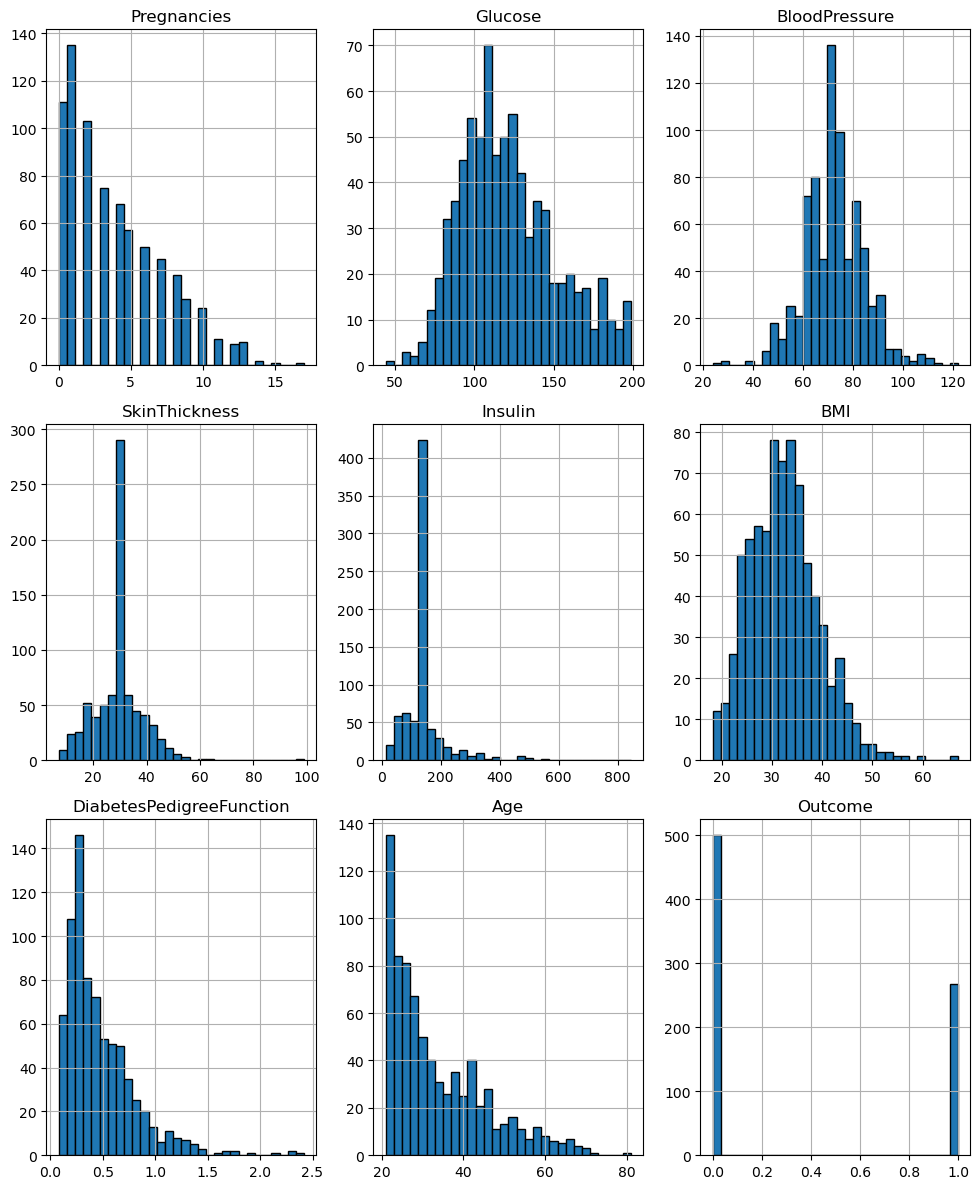

In [4]:
clean_df.hist(figsize = (10,12), bins = 30, edgecolor = 'black') #Rule of thumb for bin specification
plt.tight_layout()
plt.show()
#Most plots seem to be right skewed or normal, mainly due to presense of 0. For example:
# A large number of women in our dataset have not been pregnant, or have only been pregnant once or twice. 
# Also, our median replacement creates large spikes at the median of our column for a lot of our predictors. It may be worth
# Looking into dropping Nan values instead of replacing, will look into on a later step in the process

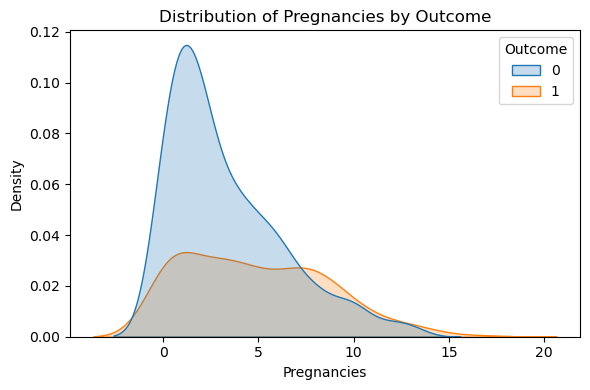

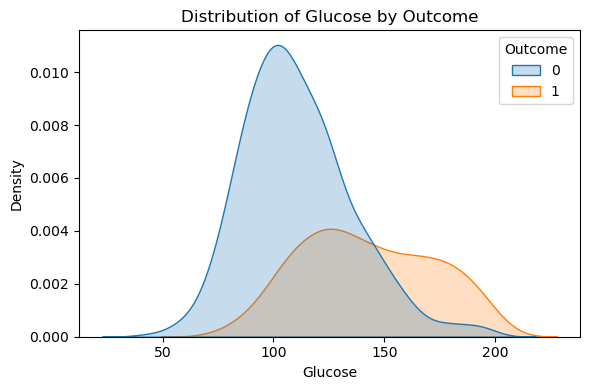

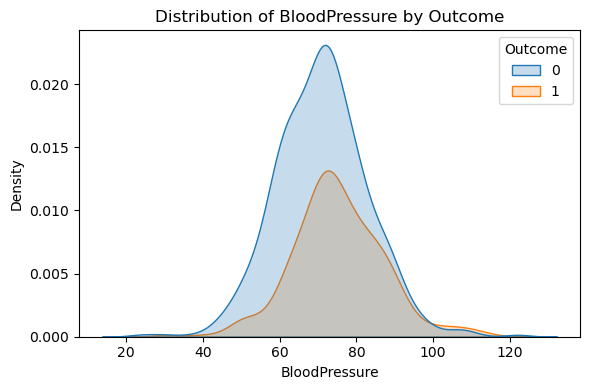

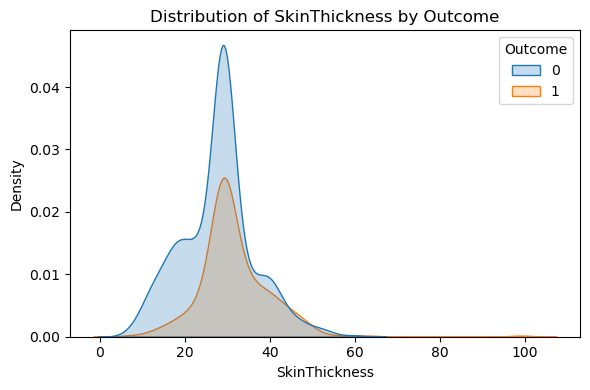

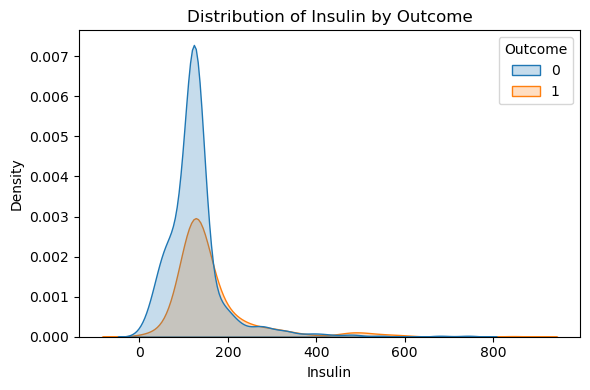

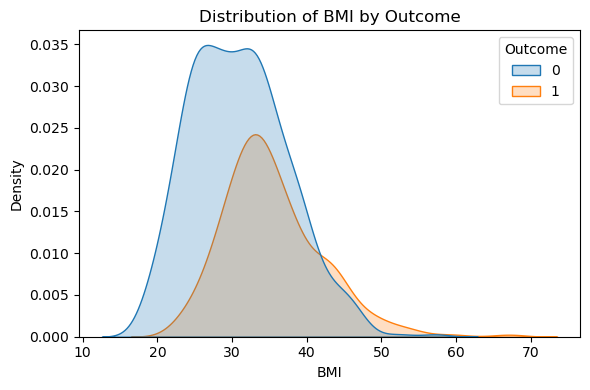

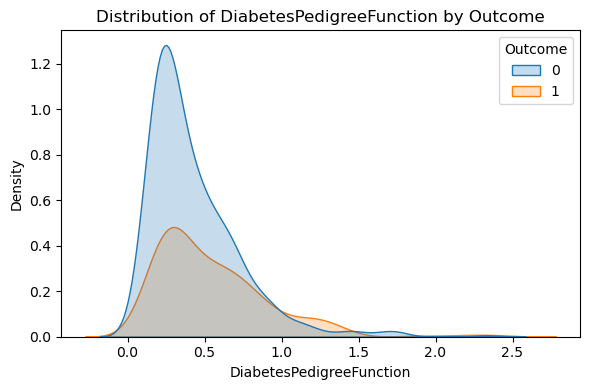

In [5]:
predictors = ["Pregnancies", "Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI", "DiabetesPedigreeFunction"]
for col in predictors:
    plt.figure(figsize = (6,4))
    sns.kdeplot(data = clean_df, x = col, hue = "Outcome", fill = True)
    plt.title(f"Distribution of {col} by Outcome")
    plt.tight_layout()
    plt.show()
#Here we see that pregnancies, glucose, skin thickness, insulin, and diabetes pedigree function have very different PDFs per outcome.
#Surprisingly, BMI and Blood pressure don't have extremely different PDFs per outcome in comparison to other predictors.
#However, all variables could be reasonably assumed to be influential on diabetes. More investigation is needed

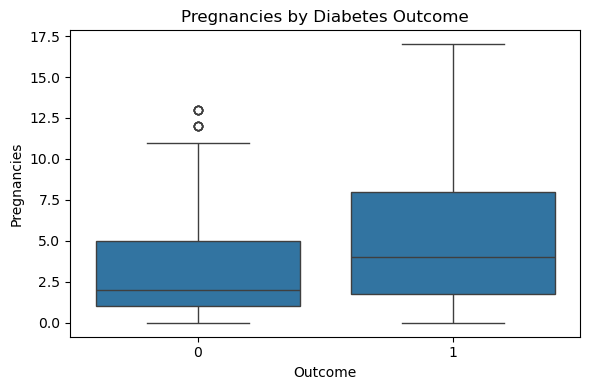

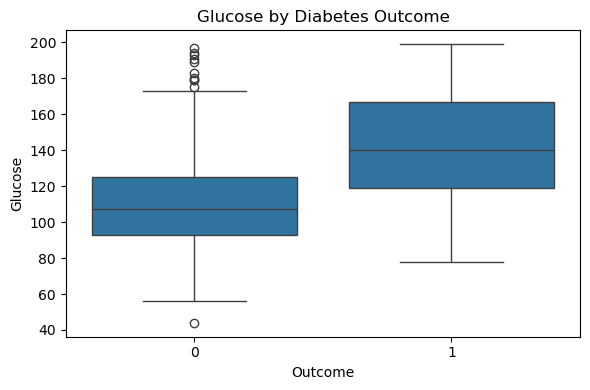

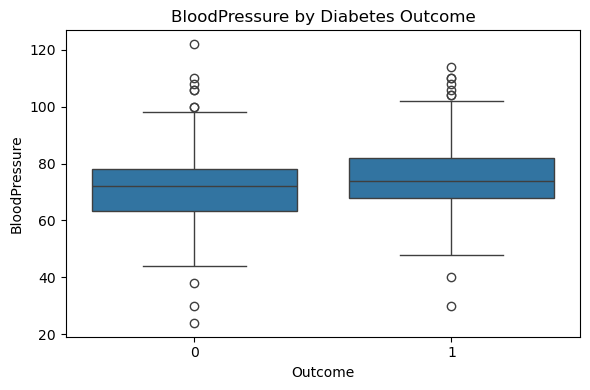

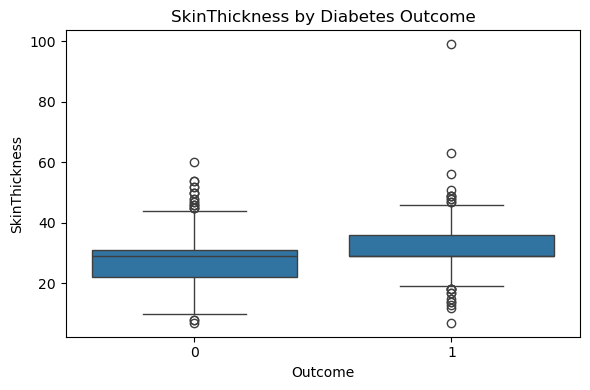

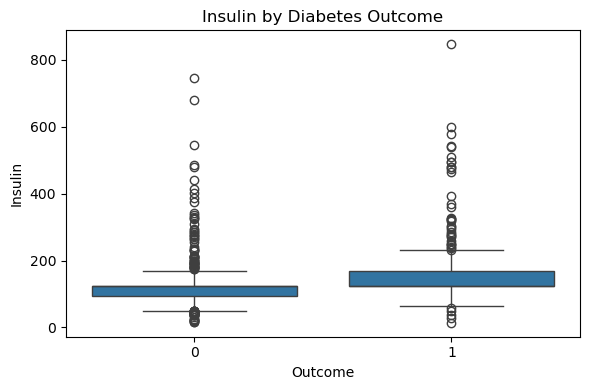

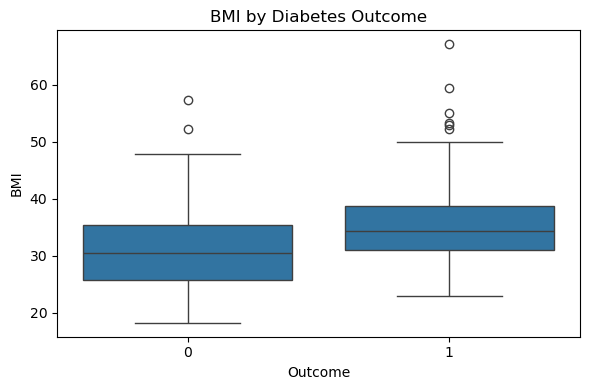

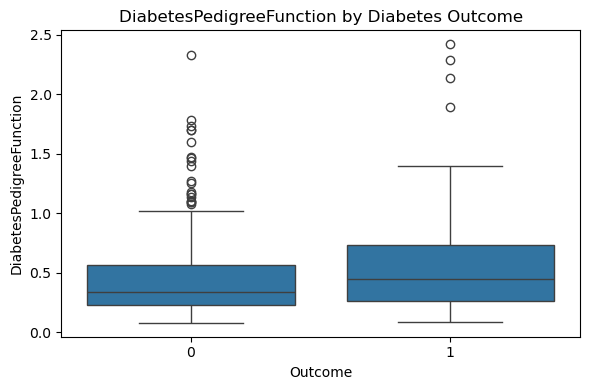

In [6]:
for col in predictors: 
    plt.figure(figsize = (6,4))
    sns.boxplot(x = "Outcome", y = col, data = clean_df)
    plt.title (f"{col} by Diabetes Outcome")
    plt.tight_layout()
    plt.show()

There are clear differences by outcome for BMI, Insulin, SkinThickness, BloodPressure, Glucose, and Pregnancies. Since we have relatively clear class seperation, a supervised model (labeled data) will work. No feature is completely dominant over the others, so a multivariable model will work best.

Modeling (Keep in mind we are now back to using the original dataset, as cleaning before splitting can lead to data leakage):

In [7]:
#Step 0: Cleaning Transformer
class ZerotoNan(BaseEstimator, TransformerMixin): 
    "Replace false zeroes with Nans in specified columns"
    def __init__(self, columns): 
        self.columns = columns
    def fit(self, X, y = None):
        return self 
    def transform(self, X):
        X = X.copy()
        cols = [c for c in self.columns if c in X.columns]
        X[cols] = X[cols].replace(0, np.nan)
        return X
#Step 1: Initializing Models: 
models = { "Logistic Regression": LogisticRegression(random_state = 42, max_iter = 1000),
          "Random forest": RandomForestClassifier(random_state = 42),
          #Not linearly separable, so default kernel
          "Support Vector Machine": SVC(probability = True, random_state = 42)
         }
#Step 2: Splitting data before cleaning, to prevent data leakage
X = df.drop("Outcome", axis = 1)
y = df["Outcome"].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42, stratify = y)

results = []
fitted = {}

#Step 3: Applying 0 transformer, then imputing using median, scaling values, and applying classifier
for name, clf in models.items():
    pipe = Pipeline ([
        ("ZerotoNan", ZerotoNan(["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI", "DiabetesPedigreeFunction"])),
        ('imputer', SimpleImputer(strategy = 'median')),
        ('scaler', StandardScaler()), 
        ('clf', clf)
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1] if hasattr(pipe, "predict_proba") else None

    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "ROC AUC Score": roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan,
    })
    fitted[name] = pipe
results_df = pd.DataFrame(results).sort_values(by = "ROC AUC Score", ascending = False).reset_index(drop = True)
print(results_df)
          

                    Model  Accuracy  Precision    Recall  F1 Score  \
0           Random forest  0.772727   0.702128  0.611111  0.653465   
1     Logistic Regression  0.707792   0.600000  0.500000  0.545455   
2  Support Vector Machine  0.740260   0.652174  0.555556  0.600000   

   ROC AUC Score  
0       0.818056  
1       0.812963  
2       0.796389  


Looking at our Accuracy, Precision, Recall, and F1 scores, we're at 60% - 80%. Next, I'm going to work on model tuning through hyperparameter tuning, and a confusion matrix and ROC curve for the best model. 

Best ROC AUC: Random forest

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.86      0.83       100
           1       0.70      0.61      0.65        54

    accuracy                           0.77       154
   macro avg       0.75      0.74      0.74       154
weighted avg       0.77      0.77      0.77       154



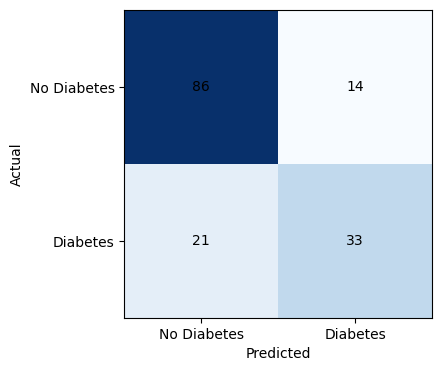

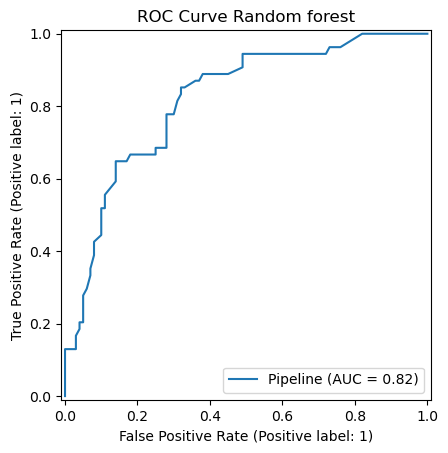

In [8]:
best_name = results_df.loc[0, "Model"]
best_model = fitted[best_name]
print(f"Best ROC AUC: {best_name}")
y_pred_best = best_model.predict(X_test)
y_proba_best = best_model.predict_proba(X_test)[:, 1] if hasattr(best_model, "predict_proba") else None
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best,zero_division = 0))
cm = confusion_matrix(y_test, y_pred_best)
fig, ax = plt.subplots(figsize=(5,4))
im = ax.imshow(cm, cmap="Blues") 
ax.set_xlabel("Predicted"); ax.set_ylabel("Actual")
ax.set_xticks([0,1]); ax.set_yticks([0,1])
ax.set_xticklabels(["No Diabetes","Diabetes"]); ax.set_yticklabels(["No Diabetes","Diabetes"])
for (i, j), val in np.ndenumerate(cm):
    ax.text(j, i, int(val), ha="center", va="center")
plt.show()
RocCurveDisplay.from_estimator(best_model, X_test, y_test)
plt.title(f"ROC Curve {best_name}")
plt.show()


Hyperparameter Tuning

In [13]:
rf_pipe = Pipeline ([
        ("ZerotoNan", ZerotoNan(["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI", "DiabetesPedigreeFunction"])),
        ('imputer', SimpleImputer(strategy = 'median')),
        ('scaler', StandardScaler()), 
        ('clf', RandomForestClassifier(random_state = 42, class_weight = "balanced"))
    ])
param_dist = {
    "clf__n_estimators": randint(100,600),
    "clf__max_depth": randint(2,20),
    "clf__min_samples_split": randint(2,20),
    "clf__min_samples_leaf": randint(1,10),
    "clf__max_features": ["sqrt","log2", None],
}
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
rf_search = RandomizedSearchCV(
    rf_pipe,
    param_distributions=param_dist,
    n_iter=40,
    scoring="roc_auc",
    n_jobs= -1,
    cv=cv,
    random_state=42,
    verbose=1,
)
rf_search.fit(X_train, y_train)
rf_best = rf_search.best_estimator_
print("Best Random Forest Parameters:", rf_search.best_params_)
print("Best CV ROC AUC:", rf_search.best_score_)

y_pred_tuned = rf_best.predict(X_test)
y_proba_tuned = rf_best.predict_proba(X_test)[:,1]

tuned_metrics = {
    "Model": "Random Forest (Tuned)",
    "Accuracy": accuracy_score(y_test, y_pred_tuned),
    "Precision": precision_score(y_test, y_pred_tuned, zero_division=0),
    "Recall": recall_score(y_test, y_pred_tuned, zero_division=0),
    "F1 Score": f1_score(y_test, y_pred_tuned, zero_division=0),
    "ROC AUC Score": roc_auc_score(y_test, y_proba_tuned),
}
compare_df = (pd.concat([results_df, pd.DataFrame([tuned_metrics])], ignore_index=True)
                .sort_values(by="ROC AUC Score", ascending=False)
                .reset_index(drop=True))
print(compare_df)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best Random Forest Parameters: {'clf__max_depth': 4, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 2, 'clf__n_estimators': 104}
Best CV ROC AUC: 0.8405357142857144
                    Model  Accuracy  Precision    Recall  F1 Score  \
0           Random forest  0.772727   0.702128  0.611111  0.653465   
1   Random Forest (Tuned)  0.740260   0.606061  0.740741  0.666667   
2     Logistic Regression  0.707792   0.600000  0.500000  0.545455   
3  Support Vector Machine  0.740260   0.652174  0.555556  0.600000   

   ROC AUC Score  
0       0.818056  
1       0.816852  
2       0.812963  
3       0.796389  


Conclusion: 
Our Random Forest Tuned Model ended up being the best overall. In screening situations, recall is typically prioritized, as we want to capture as many true positives as possible. 
In terms of our test metrics, we have an accuracy of 74%, precision of 60%, recall of 74%, f1 score of 66%, and a ROC AUC of 82%.
Also, since our CV best AUC is 84%, and our test AUC is 82%, we are relatively close, meaning we do not have overfitting. 